# NLP Project Tutorial

## Importar librerías

In [17]:
# 📦 Librerías estándar
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 🌐 NLP con NLTK
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ☁️ Visualización de texto
from wordcloud import WordCloud

# 🔠 Vectorización de texto
from sklearn.feature_extraction.text import TfidfVectorizer

# 🔀 División de datos
from sklearn.model_selection import train_test_split

# 🤖 Modelo y optimización
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# 📊 Evaluación del modelo
from sklearn.metrics import classification_report, roc_auc_score

## Cargar el conjunto de datos

In [5]:
# Cargar el dataset desde la URL
url = "https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv"
df = pd.read_csv(url)

# Mostrar las primeras filas
print(df.head())

# Ver nombres de columnas y tipos
print(df.info())

# Distribución de la variable objetivo
print(df['is_spam'].value_counts())

                                                 url  is_spam
0  https://briefingday.us8.list-manage.com/unsubs...     True
1                             https://www.hvper.com/     True
2                 https://briefingday.com/m/v4n3i4f3     True
3   https://briefingday.com/n/20200618/m#commentform    False
4                        https://briefingday.com/fan     True
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB
None
is_spam
False    2303
True      696
Name: count, dtype: int64


In [ ]:
# Guardar el DataFrame en un archivo CSV en la carpeta raw
df.to_csv("/workspaces/efrainnalmeida-NLP-project-tutorial/data/raw/url_spam.csv", index=False)

## Preprocesar los enlaces

### Conversión de etiquetas y limpieza de duplicados

In [6]:
# Convertir la etiqueta booleana a binaria
df["label"] = df["is_spam"].astype(int)

# Eliminar duplicados
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# Estadísticas rápidas
print(f"Total ejemplos: {len(df)}")
print(f"Spam: {df['label'].sum()}")
print(f"No spam: {len(df) - df['label'].sum()}")


Total ejemplos: 2369
Spam: 244
No spam: 2125


### Preprocesamiento del texto

#### Limpieza de URLs

In [ ]:
def preprocess_url(text):
    # Convertir a minúsculas
    text = text.lower()
    
    # Eliminar protocolo (http, https) y www
    text = re.sub(r'https?://(www\.)?', '', text)

    # Reemplazar caracteres no alfanuméricos por espacios
    text = re.sub(r'[^a-z0-9]', ' ', text)

    # Eliminar múltiples espacios
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

df["clean_url"] = df["url"].apply(preprocess_url)

#### Tokenización + Lematización + Stopwords

In [ ]:
# Descargar recursos necesarios
download("wordnet")
download("stopwords")
download("omw-1.4")

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def tokenize_lemmatize(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [token for token in tokens if token not in stop_words and len(token) > 3]
    return ' '.join(tokens)

df["processed_url"] = df["clean_url"].apply(tokenize_lemmatize)

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /home/vscode/nltk_data...


### WordCloud

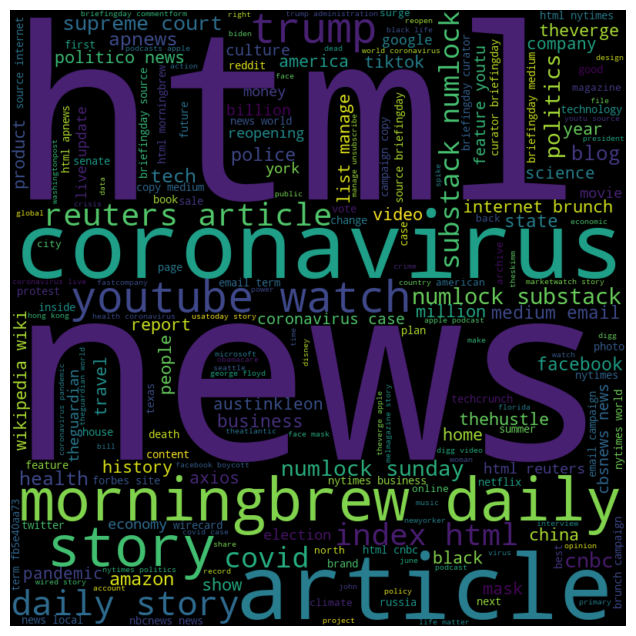

In [ ]:
wordcloud = WordCloud(width=800, height=800, background_color='black', max_words=1000, min_font_size=10, random_state=42)\
    .generate(' '.join(df["processed_url"]))

plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Vectorización TF-IDF

In [11]:
vectorizer = TfidfVectorizer(max_features=5000, max_df=0.8, min_df=5)
X = vectorizer.fit_transform(df["processed_url"])
y = df["label"]

### División Train/Test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# Concatenar X_train y y_train
train_df = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())
train_df["label"] = y_train.values
train_df.to_csv("/workspaces/efrainnalmeida-NLP-project-tutorial/data/processed/train.csv", index=False)

In [16]:
# Concatenar X_test y y_test
test_df = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out())
test_df["label"] = y_test.values
test_df.to_csv("/workspaces/efrainnalmeida-NLP-project-tutorial/data/processed/test.csv", index=False)

## Construir una SVM

### Entrenamiento y Evaluación con SVM

In [13]:
# Entrenar modelo SVM lineal
model = SVC(kernel='linear', probability=True, random_state=42)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Para ROC AUC

### Métricas de evaluación

In [14]:
# Reporte de clasificación
print("🔍 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["No Spam", "Spam"]))

# ROC AUC Score
roc_score = roc_auc_score(y_test, y_proba)
print(f"🔵 ROC AUC Score: {roc_score:.4f}")

🔍 Classification Report:

              precision    recall  f1-score   support

     No Spam       0.94      1.00      0.97       425
        Spam       0.92      0.45      0.60        49

    accuracy                           0.94       474
   macro avg       0.93      0.72      0.78       474
weighted avg       0.94      0.94      0.93       474

🔵 ROC AUC Score: 0.8912


## Optimizar el modelo anterior

In [19]:
# Definir hiperparámetros
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "sigmoid", "poly"],
    "degree": [2, 3],  # solo aplica a kernel "poly"
    "gamma": ["scale", "auto"]
}

# Instanciar GridSearchCV
grid_search = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Ajustar el modelo
grid_search.fit(X_train, y_train)

# Ver mejores hiperparámetros
print("✅ Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Evaluar automáticamente el mejor modelo
best_model = grid_search.best_estimator_

# Predicciones
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Reporte de clasificación
print("\n🔍 Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["No Spam", "Spam"]))

# ROC AUC Score
roc_score = roc_auc_score(y_test, y_proba)
print(f"🔵 ROC AUC Score: {roc_score:.4f}")

Fitting 5 folds for each of 80 candidates, totalling 400 fits
✅ Mejores hiperparámetros encontrados:
{'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'rbf'}

🔍 Classification Report:

              precision    recall  f1-score   support

     No Spam       0.90      1.00      0.95       425
        Spam       0.00      0.00      0.00        49

    accuracy                           0.90       474
   macro avg       0.45      0.50      0.47       474
weighted avg       0.80      0.90      0.85       474

🔵 ROC AUC Score: 0.8992


/workspaces/efrainnalmeida-NLP-project-tutorial/env1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/workspaces/efrainnalmeida-NLP-project-tutorial/env1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/workspaces/efrainnalmeida-NLP-project-tutorial/env1/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavi

## Guardar el modelo

In [20]:
import pickle

# Ruta de guardado
model_path = "/workspaces/efrainnalmeida-NLP-project-tutorial/models/best_svm_model.pkl"

# Guardar el modelo
with open(model_path, "wb") as file:
    pickle.dump(best_model, file)

print("✅ Modelo guardado exitosamente en:", model_path)

✅ Modelo guardado exitosamente en: /workspaces/efrainnalmeida-NLP-project-tutorial/models/best_svm_model.pkl
